In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('WB.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Decreased'

In [5]:
df.Date.describe()

count           115
unique          115
top       16-Mar-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,0,0,0
1,15-Mar-20,0,0,0
2,16-Mar-20,0,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,0,0,0
...,...,...,...,...
110,02-Jul-20,649,509,16
111,03-Jul-20,669,534,18
112,04-Jul-20,743,595,19
113,05-Jul-20,895,545,21


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,0,0,0
1,2020-03-15,0,0,0
2,2020-03-16,0,0,0
3,2020-03-17,1,0,0
4,2020-03-18,0,0,0


In [9]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,0,0,0
1,2020-03-15,0,0,0
2,2020-03-16,0,0,0
3,2020-03-17,1,0,0
4,2020-03-18,0,0,0
...,...,...,...,...
110,2020-07-02,649,509,16
111,2020-07-03,669,534,18
112,2020-07-04,743,595,19
113,2020-07-05,895,545,21


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,0,0,0
2020-03-15,0,0,0
2020-03-16,0,0,0
2020-03-17,1,0,0
2020-03-18,0,0,0
...,...,...,...
2020-07-02,649,509,16
2020-07-03,669,534,18
2020-07-04,743,595,19


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,0,0,0
2020-03-15,0,0,0
2020-03-16,0,0,0
2020-03-17,1,0,0
2020-03-18,0,0,0
...,...,...,...
2020-07-02,649,509,16
2020-07-03,669,534,18
2020-07-04,743,595,19


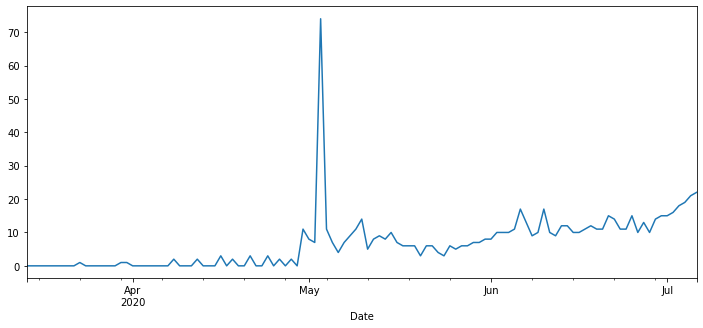

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.909787
p-value                   0.044222
# lags used               2.000000
# observations          112.000000
critical value (1%)      -3.490131
critical value (5%)      -2.887712
critical value (10%)     -2.580730
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


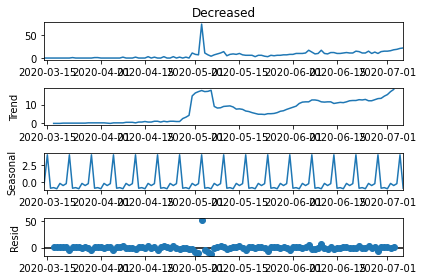

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.980177e+00
p-value                 1.846519e-07
# lags used             1.100000e+01
# observations          1.010000e+02
critical value (1%)    -3.496818e+00
critical value (5%)    -2.890611e+00
critical value (10%)   -2.582277e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=2)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=827.789, BIC=833.261, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=801.821, BIC=810.030, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=776.287, BIC=784.496, Time=0.031 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=825.841, BIC=828.578, Time=0.010 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=774.946, BIC=785.890, Time=0.175 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=775.474, BIC=786.418, Time=0.164 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=779.372, BIC=793.053, Time=0.165 seconds
Total fit 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -383.473
Date:                Tue, 14 Jul 2020   AIC                            774.946
Time:                        16:00:00   BIC                            785.890
Sample:                             0   HQIC                           779.387
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1245      0.057      2.187      0.029       0.013       0.236
ar.L1          0.1731      0.111      1.556      0.120      -0.045       0.391
ma.L1         -0.9999     14.241     -0.070      0.944     -28.912      26.912
sigma2        47.0523    668.098      0.070      0.944   -1262.396    1356.501
===================================================================================
Ljung-Box (Q):                       13.54   Jarque-Bera (JB):             34227.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             8.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        86.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:90]
test = df.iloc[90:]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(1, 1, 1))
model = SARIMAX(train[para],order=(1, 1, 1),seasonal_order=(1,1,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Decreased   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 2)   Log Likelihood                -309.034
Date:                           Tue, 14 Jul 2020   AIC                            628.067
Time:                                   16:00:00   BIC                            640.397
Sample:                               03-14-2020   HQIC                           633.032
                                    - 06-11-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0913      0.164      0.555      0.579      -0.231       0.414
ma.L1         -0.8834      0.137     -6.471      0.000      -1.151      -0.616
ar.S.L2        0.0452      0.145      0.312      0.755      -0.239       0.329
ma.S.L2       -0.9997     25.084     -0.040      0.968     -50.164      48.165
sigma2        62.4257   1560.467      0.040      0.968   -2996.034    3120.886
===================================================================================
Ljung-Box (Q):                        8.82   Jarque-Bera (JB):             13961.62
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              26.78   Skew:                             7.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,1,2) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

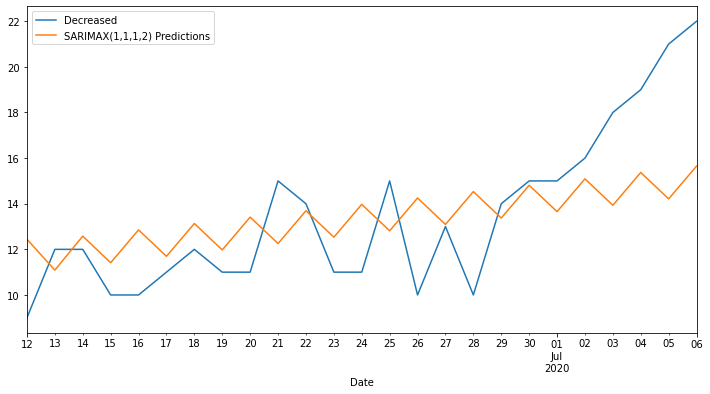

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAPE = mean_absolute_error(predictions, test[para])
MAPE

2.2777064373881086

In [28]:
per_MAPE = (MAPE/sum(test[para]))*100
print(per_MAPE,'%')

0.6758772811240679 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,0,0,0,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,0,0,0,0.0,NaN
2020-03-17,1,0,0,0.0,NaN
2020-03-18,0,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,649,509,16,1.0,15.090571
2020-07-03,669,534,18,1.0,13.932260
2020-07-04,743,595,19,-1.0,15.370284


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Decreased': Date
 2020-06-12     9
 2020-06-13    12
 2020-06-14    12
 2020-06-15    10
 2020-06-16    10
 2020-06-17    11
 2020-06-18    12
 2020-06-19    11
 2020-06-20    11
 2020-06-21    15
 2020-06-22    14
 2020-06-23    11
 2020-06-24    11
 2020-06-25    15
 2020-06-26    10
 2020-06-27    13
 2020-06-28    10
 2020-06-29    14
 2020-06-30    15
 2020-07-01    15
 2020-07-02    16
 2020-07-03    18
 2020-07-04    19
 2020-07-05    21
 2020-07-06    22
 Freq: D, Name: Decreased, dtype: int64,
 'Predicted_Decreased': 2020-06-12    12.443080
 2020-06-13    11.089552
 2020-06-14    12.579283
 2020-06-15    11.412722
 2020-06-16    12.853136
 2020-06-17    11.694457
 2020-06-18    13.132590
 2020-06-19    11.974262
 2020-06-20    13.412291
 2020-06-21    12.253980
 2020-06-22    13.692004
 2020-06-23    12.533693
 2020-06-24    13.971718
 2020-06-25    12.813407
 2020-06-26    14.251431
 2020-06-27    13.093120
 2020-06-28    14.531144
 2020-06-29    13.372833
 2020-06-30    14

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Decreased,Predicted_Decreased
Date,,
2020-06-12,9,12.443080
2020-06-13,12,11.089552
2020-06-14,12,12.579283
2020-06-15,10,11.412722
2020-06-16,10,12.853136
2020-06-17,11,11.694457
2020-06-18,12,13.132590
2020-06-19,11,11.974262
2020-06-20,11,13.412291


In [33]:
# predicted_df.to_csv('Predicted_WB.csv')
predicted_csv = pd.read_csv('Predicted_WB.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_WB.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered  \
Date                                                                         
2020-06-12        476           480.036247        218           195.557874   
2020-06-13        454           511.275847        336           187.541265   
2020-06-14        389           500.677207        518           193.747774   
2020-06-15        407           514.906621        434           199.037744   
2020-06-16        415           521.360034        534           213.281947   
2020-06-17        391           469.183379        505           251.569163   
2020-06-18        435           486.885003        468           240.960535   
2020-06-19        355           543.296845        302           228.959115   
2020-06-20        441           565.444740        562           203.169181   
2020-06-21        414           604.497600        432           239.733794   
2020-06-22        413           598.776678        390           

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,0,0,0,NaN
2020-03-15,0,0,0,NaN
2020-03-16,0,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,0,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Decreased,forecast
2020-03-14,0,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

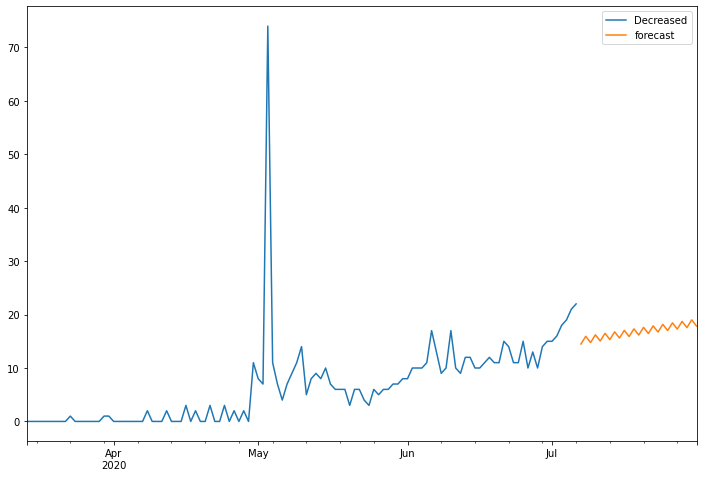

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Decreased': 2020-07-07    14.491687
 2020-07-08    15.929711
 2020-07-09    14.771400
 2020-07-10    16.209424
 2020-07-11    15.051113
 2020-07-12    16.489138
 2020-07-13    15.330827
 2020-07-14    16.768851
 2020-07-15    15.610540
 2020-07-16    17.048564
 2020-07-17    15.890253
 2020-07-18    17.328278
 2020-07-19    16.169967
 2020-07-20    17.607991
 2020-07-21    16.449680
 2020-07-22    17.887704
 2020-07-23    16.729393
 2020-07-24    18.167418
 2020-07-25    17.009107
 2020-07-26    18.447131
 2020-07-27    17.288820
 2020-07-28    18.726845
 2020-07-29    17.568533
 2020-07-30    19.006558
 2020-07-31    17.848247
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Decreased
2020-07-07,14.491687
2020-07-08,15.929711
2020-07-09,14.771400
2020-07-10,16.209424
2020-07-11,15.051113
2020-07-12,16.489138
2020-07-13,15.330827
2020-07-14,16.768851
2020-07-15,15.610540
2020-07-16,17.048564


In [44]:
# future_predicted_df.index.names = ['Date']
# future_predicted_df.index.freq = 'D'
# future_predicted_df.to_csv('Future_Predicted_WB.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_WB.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_WB.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered  \
Date                                                                 
2020-07-07                  872.550449                  317.687081   
2020-07-08                  841.864642                  318.863798   
2020-07-09                  870.818906                  343.952773   
2020-07-10                  881.674017                  347.564437   
2020-07-11                  828.086136                  335.285986   
2020-07-12                  859.877723                  363.704672   
2020-07-13                  916.093254                  363.162731   
2020-07-14                  946.111125                  391.412030   
2020-07-15                 1029.870908                  375.745503   
2020-07-16                 1009.111592                  368.223952   
2020-07-17                 1038.005734                  369.400668   
2020-07-18                 1037.934598                  394.489643   
2020-07-19          